In [1]:
from __future__ import unicode_literals
from functools import partial
from hazm import Stemmer, Lemmatizer, Normalizer, WordTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score,precision_recall_curve
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix, f1_score, make_scorer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
import time
import os
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Building Language Model

In [2]:
colnames = [i for i in range(15)]
web_data = pd.read_csv("data/web.csv", names = colnames, header=None)
print(len(web_data))
web_data.tail()

11564


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
11559,4143463,1varzesh.com/football/turkey/superlig/2018-19/...,روزهای بد امیری در سوپرلیگ ترکیه - یک ورزش به ...,روزهای بد امیری در سوپرلیگ ترکیه,لژیونر فوتبال ایران در تیم ترابزون اسپور روزها...,روزهای بد امیری در سوپرلیگ ترکیه - یک ورزش,لژیونر فوتبال ایران در تیم ترابزون اسپور روزها...,"['امیری', 'ترکیه', 'رده', 'وحید', 'سید', 'میدا...",NaN,13.0,0.517595,"{""13"": 0.517595361945674, ""31"": 0.001317263397...",2018-10-27 12:45:37.458226+03:30,2018-10-27 12:45:37.458193+03:30,"{""13"": {""probability"": ""0.517595361945674"", ""s..."
11560,4182366,1varzesh.com/football/turkey/superlig/2018-19/...,تساوی ترابزون اسپور با امیری و حسینی - یک ورزش...,تساوی ترابزون اسپور با امیری و حسینی,تیم فوتبال ترابزون اسپور که در ترکیب از بازیکن...,تساوی ترابزون اسپور با امیری و حسینی - یک ورزش,تیم فوتبال ترابزون اسپور که در ترکیب از بازیکن...,"['حسینی', 'امیری', 'ورزش', 'لیگ', 'اسپور', 'تر...",NaN,13.0,0.757363,"{""13"": 0.7573625064373598, ""31"": 0.00115572814...",2018-10-28 08:31:13.801743+03:30,2018-10-28 08:31:13.801728+03:30,"{""13"": {""probability"": ""0.7573625064373598"", ""..."
11561,4709354,1varzesh.com/football/turkey/superlig/2018-19/...,شکست سنگین ترابزون با حسینی - یک ورزش ترابزون ...,شکست سنگین ترابزون با حسینی,ترابزون اسپور که در ترکیب از بازیکن ایرانی‌اش ...,شکست سنگین ترابزون با حسینی - یک ورزش,ترابزون اسپور که در ترکیب از بازیکن ایرانی‌اش ...,"['ورزش', 'گل', 'حسینی', 'ذخیره', 'ترابزون', 'ت...",NaN,13.0,0.607256,"{""13"": 0.6072557407472986, ""31"": 0.00925766676...",2018-11-10 08:29:17.356765+03:30,2018-11-10 08:29:17.35675+03:30,"{""13"": {""probability"": ""0.6072557407472986"", ""..."
11562,4813259,1varzesh.com/football/turkey/superlig/2018-19/...,یک تیم لالیگایی به دنبال حسینی - یک ورزش به نق...,یک تیم لالیگایی به دنبال حسینی,سایت ترکیه‌ای از ابراز علاقه یک تیم اسپانیایی ...,یک تیم لالیگایی به دنبال حسینی - یک ورزش,سایت ترکیه‌ای از ابراز علاقه یک تیم اسپانیایی ...,"['باشگاه', 'ورزش', 'حسینی', 'سید', 'ترکی', 'پی...",NaN,13.0,0.446687,"{""13"": 0.4466869902891258, ""31"": 0.00276182980...",2018-11-12 15:19:24.998229+03:30,2018-11-12 15:19:24.99821+03:30,"{""13"": {""probability"": ""0.4466869902891258"", ""..."
11563,5523973,1varzesh.com/football/turkey/superlig/2018-19/...,پیروزی ترابزون در شب گلزنی امیری - یک ورزش ترا...,پیروزی ترابزون در شب گلزنی امیری,ترابزون اسپور با گلزنی بازیکن ایرانی خود توانس...,پیروزی ترابزون در شب گلزنی امیری - یک ورزش,ترابزون اسپور با گلزنی بازیکن ایرانی خود توانس...,"['گل', 'ترابزون', 'ورزش', 'امیری', 'میدان', 'ت...",NaN,13.0,0.732303,"{""21"": 0.00431195253124086, ""18"": 0.1135478983...",2018-12-02 02:08:46.117319+03:30,2018-12-02 02:08:46.117307+03:30,"{""13"": {""probability"": ""0.7323029334228653"", ""..."


In [3]:
informative_cols = [1,2,3,4,5,6,7]
web_data = web_data[informative_cols]

In [4]:
with open("data/wiki.txt") as f:
    wiki_data = f.readlines()

In [5]:
target_col = 2
corpus = np.concatenate([web_data[2],wiki_data])
print(f"corpus shape:{corpus.shape}")

corpus shape:(31564,)


In [6]:
def mytokenizer(stemmer,lemmatizer, word_tokenizer,document):
    tokens = word_tokenizer.tokenize(document)
    tokens = [lemmatizer.lemmatize(stemmer.stem(token)) for token in tokens]
    return tokens

In [7]:
normalizer = Normalizer(persian_numbers=False)
stemmer = Stemmer()
lemmatizer = Lemmatizer()
word_tokenizer = WordTokenizer(replace_emails=True, replace_links=True, replace_IDs=True)
tokenizer=partial(mytokenizer, stemmer, lemmatizer, word_tokenizer)

In [14]:
start = time.time()
cv = CountVectorizer(preprocessor=normalizer.normalize,tokenizer=tokenizer)
cv.fit(corpus)
print(f"Fit time: {time.time()-start}s")
print(f"vocab size: {len(cv.vocabulary_)}")
joblib.dump(cv.vocabulary_,"saved_models/cv_vocab.pkl")

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


vocab size: 265497


['cv_vocab.pkl']

In [8]:
vocab = joblib.load("saved_models/cv_vocab.pkl")

In [9]:
start = time.time()
tfidf = TfidfVectorizer(preprocessor=normalizer.normalize,
                        tokenizer=tokenizer,
                        vocabulary=vocab)
tfidf.fit(corpus)
print(f"Fit time: {time.time()-start}s")

Fit time: 260.7113573551178s


In [10]:
joblib.dump(tfidf.idf_, "saved_models/idf.pkl")

['saved_models/idf.pkl']

## Looking At Scrapped Data

In [11]:
items_df = pd.read_csv("data/items.csv")
print(items_df.shape)
items_df.head()

(3563, 3)


,category,name,summary
0,مودم - روتر ADSL,مودم روتر ADSL2 Plus بی‌سیم N300 تی پی-لینک مد...,تی‌پی-لینک TD-W8961N یک مودم‌روتر +ADSL2 است ک...
1,تجهیزات جانبی ایروبیک و تناسب اندام,نیمکت بدنسازی مدل HT17,نیمکت بدنسازی تخت حرفه ای ، قابل استفاده در با...
2,تجهیزات جانبی ایروبیک و تناسب اندام,ترامپولین مکسول مدل EL120,ورزش ترامپولین اغلب به عنوان یکی از بهترین و م...
3,جاشمعی، جاعودی و آباژور,جا عودی طرح خانه قلبی کد 02,برای بسیاری از ما استفاده از بوی عود بسیار مطب...
4,تجهیزات جانبی ایروبیک و تناسب اندام,ترامپولین مدل Tsky110,ترامپولین وسیله ای مفرح جهت افزایش شادابی و تح...


In [12]:
print(items_df.isna().sum())
items_df.dropna(inplace=True)

category    0
name        0
summary     3
dtype: int64


number of unique categories: 260


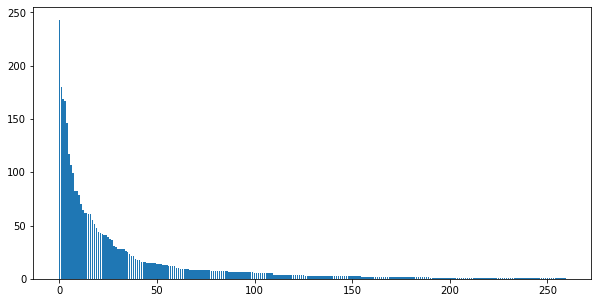

In [13]:
print(f"number of unique categories: {items_df.category.nunique()}")
value_counts = items_df.category.value_counts()
plt.figure(figsize=(10,5))
plt.bar(range(len(value_counts)),value_counts.values)
plt.show()

The long tail plot shows that many categories have small number of records. On the other hand small number of categories have many instances in dataset.

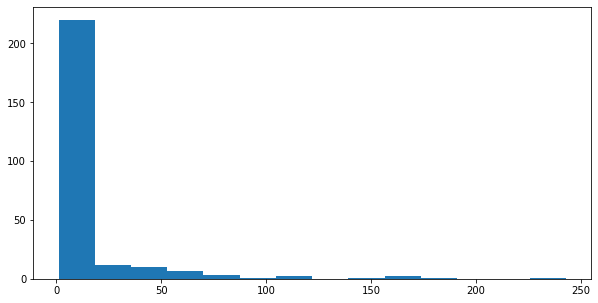

In [14]:
plt.figure(figsize=(10,5))
plt.hist(value_counts.values,bins=14)
plt.show()

This histogram shows us many categories have number of records between 1 and 10 in dataset.

max lenght: 1078, min length: 1, average length: 180
25th percentile: 107.0, 75th percentile: 238.0


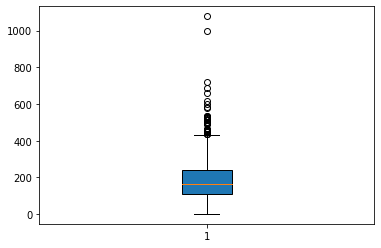

In [15]:
summaries_length = np.array([len(x.split()) for x in items_df["summary"]])
print(f"max lenght: {summaries_length.max()}, min length: {summaries_length.min()}, average length: {int(summaries_length.mean())}")
print(f"25th percentile: {np.percentile(summaries_length,25)}, 75th percentile: {np.percentile(summaries_length,75)}")
plt.boxplot(summaries_length,patch_artist=True)
plt.show()

Box plot shows that 75 percent of our records lenghtes are lower than 253 words

In [16]:
print(f"number of duplicate summaries: {len(items_df.summary) - items_df.summary.nunique()}")
print(f"number of duplicate name: {len(items_df.name) - items_df.name.nunique()}")

number of duplicate summaries: 209
number of duplicate name: 27


duplicate summaries must be removed because information from validation and test data could be leaked

In [17]:
items_df = items_df.drop_duplicates(subset="summary").drop_duplicates(subset="name")
print("no unique items scrapped:", len(items_df))

no unique items scrapped: 3332


In [18]:
items_df.category = items_df.category.astype("category")
items_df.category.cat.categories[:10]

Index(['category', 'آرام بند', 'آغوشی', 'آمپلی‌فایر', 'آچار', 'آینه',
       'آینه دست‌ساز', 'آینه دوچرخه', 'ابزار بایگانی', 'ابزار دوچرخه'],
      dtype='object')

we just use classes with sufficient number of record so model can learn useful patterns.

In [19]:
threshold = 20
value_counts = items_df["category"].value_counts().sort_values(ascending=False)
target_cats = value_counts[value_counts >= threshold].index
print(target_cats)
print(f"number of target categories: {len(target_cats)}")

CategoricalIndex(['لپ تاپ و الترابوک', 'هدفون، هدست و هندزفری', 'گوشی موبایل',
                  'پاوربانک (شارژر همراه)', 'تبلت', 'قمقمه و فلاسک', 'قفل',
                  'کتاب چاپی', 'تجهیزات جانبی ایروبیک و تناسب اندام', 'مداد',
                  'اصلاح موی صورت', 'روغن موتور', 'کیف و کوله',
                  'چاقوی سفر و ابزار چند کاره', 'چندراهی برق و محافظ ولتاژ',
                  'اتو و حالت دهنده ی مو', 'ساعت هوشمند', 'خودکار و روان نویس',
                  'ماشین حساب', 'روغن', 'میکروفون حرفه‌ای', 'دفتر',
                  'دوربین عکاسی', 'برنج', 'کرم ضد آفتاب', 'کیف و کاور گوشی',
                  'توپ', 'پوشک کودک و نوزاد', 'ماست', 'شیرآلات', 'پنیر',
                  'ریمل', 'کابل و مبدل', 'ست لباس راحتی پسرانه',
                  'شامپو کودک و نوزاد', 'کارت حافظه',
                  'کرم، بالم و لوسیون کودک و نوزاد',
                  'پایه نگهدارنده گوشی و تبلت', 'باتری استاندارد'],
                 categories=['category', 'آرام بند', 'آغوشی', 'آمپلی‌فایر', 'آچار', 'آین

In [20]:
#writing target categories to a file so tha wikiscrapper will scrap data for each category available in wikipedia
wiki_target_cats_path = "wikiscrapper/categories"
with open(wiki_target_cats_path,"w+") as f:
    for cat in target_cats:
        f.write(cat + "\n")

In [21]:
items_df.head()

,category,name,summary
0,مودم - روتر ADSL,مودم روتر ADSL2 Plus بی‌سیم N300 تی پی-لینک مد...,تی‌پی-لینک TD-W8961N یک مودم‌روتر +ADSL2 است ک...
1,تجهیزات جانبی ایروبیک و تناسب اندام,نیمکت بدنسازی مدل HT17,نیمکت بدنسازی تخت حرفه ای ، قابل استفاده در با...
2,تجهیزات جانبی ایروبیک و تناسب اندام,ترامپولین مکسول مدل EL120,ورزش ترامپولین اغلب به عنوان یکی از بهترین و م...
3,جاشمعی، جاعودی و آباژور,جا عودی طرح خانه قلبی کد 02,برای بسیاری از ما استفاده از بوی عود بسیار مطب...
4,تجهیزات جانبی ایروبیک و تناسب اندام,ترامپولین مدل Tsky110,ترامپولین وسیله ای مفرح جهت افزایش شادابی و تح...


We don't use name because usually label is hidden in the name

In [22]:
t = items_df[items_df.category.apply(lambda cat : cat in target_cats)]
assert sorted(t.category.unique()) == sorted(target_cats)
print(len(t))
X = t["summary"]
le = LabelEncoder()
y = le.fit_transform(t["category"])
joblib.dump(le ,"saved_models/le.pkl")

2423


['saved_models/le.pkl']

## Data preparation

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=28,stratify=y,shuffle=True)
len(X_train), len(X_test)

(1938, 485)

In [24]:
X_train_idf = pd.DataFrame(tfidf.transform(X_train).toarray())
X_test_idf = pd.DataFrame(tfidf.transform(X_test).toarray())

## Model Selection And Evaluation

In [25]:
from sklearn.dummy import DummyClassifier
strategies = ["stratified","most_frequent","uniform"]
for strategy in strategies:
    cv_results = cross_val_score(DummyClassifier(strategy=strategy),X_train_idf,y_train,scoring="accuracy",cv=5)
    print(f"{strategy} strategy scores: {cv_results}")

stratified strategy scores: [0.03350515 0.04381443 0.03608247 0.03100775 0.03875969]
most_frequent strategy scores: [0.09020619 0.09278351 0.09020619 0.09043928 0.09043928]
uniform strategy scores: [0.02835052 0.03350515 0.02835052 0.02842377 0.02325581]


Baseline : 9% accuracy

In [44]:
def clf_metrics_values(preds,targets):
    accuracy = accuracy_score(targets,preds)
    
    f1_micro = f1_score(targets,preds,average="micro")
    precision_micro = precision_score(targets,preds,average="micro")
    recall_micro = recall_score(targets,preds,average="micro")
    
    f1_weighted = f1_score(targets,preds,average="micro")
    precision_weighted = precision_score(targets,preds,average="micro")
    recall_weighted = recall_score(targets,preds,average="micro")
    
    return (accuracy, f1_micro, f1_weighted ,precision_micro,precision_weighted, recall_micro,recall_weighted)

In [29]:
probs = cross_val_predict(LogisticRegression(),X_train_idf,y_train,cv=3,method="predict_proba")

In [33]:
preds = np.argmax(probs,axis=1)

In [30]:
len(probs.nonzero()[0]), len(X_train)

(75582, 1938)

This indicates that for each sample there 39 non zero probabilities that can be used to recommend multiple categories instead of recommending just class with highest probability.

In [48]:
(accuracy, f1_micro, f1_weighted ,precision_micro,precision_weighted, recall_micro,recall_weighted) = clf_metrics_values(preds,y_train)
print(f"accuracy:{accuracy}\nf1_micro:{f1_micro}\nf1_weighted:{f1_weighted}\nprecision_micro:{precision_micro}\nprecision_weighted:{precision_weighted}\nrecall_micro:{recall_micro},\nrecall_weighted:{recall_weighted}")


accuracy:0.9494324045407637
f1_micro:0.9494324045407637
f1_weighted:0.9494324045407637
precision_micro:0.9494324045407637
precision_weighted:0.9494324045407637
recall_micro:0.9494324045407637,
recall_weighted:0.9494324045407637


If a classifier obtains a large F1micro, this indicates that it performs well overall. The micro-average is not sensitive to the predictive performance for individual classes. As a consequence, the micro-average can be particularly misleading when the class distribution is imbalanced.

If F1macro has a large value, this indicates that a classifier performs well for each individual class. The macro-average is therefore more suitable for data with an imbalanced class distribution.

#### Dimentionality Reduction

In [49]:
n_samples = len(X_train)
n_features = len(vocab)
no_dims = min(n_samples,n_features)
start = time.time()
pca = PCA(n_components=no_dims, random_state=28)
X_train_dim_reduced = pca.fit_transform(X_train_idf)
X_test_dim_reduced = pca.transform(X_test_idf)
print(f"Fit time: {time.time()-start}s")

Fit time: 124.70964980125427s


In [270]:
joblib.dump(X_train_dim_reduced,"data/X_train_dim_reduced.pkl")
joblib.dump(X_test_dim_reduced,"data/X_test_dim_reduced.pkl")

['data/X_test_dim_reduced.pkl']

In [50]:
threshold = 0.8
print(f"Expained variance: {np.cumsum(pca.explained_variance_)[-1]}")
print(f"Number of dimentions to explain {threshold} total variance: {np.argmax(np.cumsum(pca.explained_variance_) > threshold)}")

Expained variance: 0.8488584789572444
Number of dimentions to explain 0.8 total variance: 981


In [51]:
class DimensionSelector(BaseEstimator,TransformerMixin):
    
    def __init__(self, num_dims=None):
        self.num_dims = num_dims
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[...,:self.num_dims]

In [54]:
scoring = {"accuracy":make_scorer(accuracy_score),
           "f1_weighted":make_scorer(f1_score,average="weighted"),
           "f1_micro":make_scorer(f1_score,average="micro")}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(), SGDClassifier(),
          LogisticRegression()]

n_samples = len(X_train)
n_features = len(vocab)
no_dims = min(n_samples,n_features)
cv = 3
step_size = 100
params = [{"dim_select__num_dims":np.linspace(no_dims,no_dims//step_size,dtype=np.int)},
         {"dim_select__num_dims":np.linspace(no_dims,no_dims//step_size,dtype=np.int)},
         {"dim_select__num_dims":np.linspace(no_dims,no_dims//step_size,dtype=np.int)},
         {"dim_select__num_dims":np.linspace(no_dims,no_dims//step_size,dtype=np.int)},
         {"dim_select__num_dims":np.linspace(no_dims,no_dims//step_size,dtype=np.int)},]

cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    pipeline = Pipeline([("dim_select",DimensionSelector()),("predictor",model)])
    gridcv = GridSearchCV(pipeline,param_grid=params[i],scoring=scoring,cv=cv,refit="accuracy",return_train_score=True)
    res = gridcv.fit(X_train_dim_reduced,y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_accuracy"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_micro = res.cv_results_["mean_test_f1_micro"][best_score_idx]
    best_f1_weighted = res.cv_results_["mean_test_f1_weighted"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_micro:{best_f1_micro}, f1_weighted:{best_f1_weighted}\n")


Model: GaussianNB, Best params: {'dim_select__num_dims': 97}
acc:0.9489164086687306, f1_micro:0.9489164086687306, f1_weighted:0.9484676155713491

Model: KNeighborsClassifier, Best params: {'dim_select__num_dims': 1938}
acc:0.9592363261093911, f1_micro:0.9592363261093911, f1_weighted:0.9580465421594021

Model: RandomForestClassifier, Best params: {'dim_select__num_dims': 253}
acc:0.957688338493292, f1_micro:0.957688338493292, f1_weighted:0.95694662466677

Model: SGDClassifier, Best params: {'dim_select__num_dims': 488}
acc:0.977296181630547, f1_micro:0.977296181630547, f1_weighted:0.9767658746940895

Model: LogisticRegression, Best params: {'dim_select__num_dims': 606}
acc:0.9530443756449948, f1_micro:0.9530443756449948, f1_weighted:0.9495052936262306



In [89]:
for model in models:
    model_name = model.__class__.__name__
    best_score_idx = np.argmax(cv_results[model_name].cv_results_["mean_test_accuracy"])
    print(model_name,"Mean Score Time:",cv_results[model_name].cv_results_["mean_score_time"][best_score_idx])
    print(model_name,"Mean Train Time:",cv_results[model_name].cv_results_["mean_fit_time"][best_score_idx])

GaussianNB Mean Score Time: 0.015824635823567707
GaussianNB Mean Train Time: 0.037443955739339195
KNeighborsClassifier Mean Score Time: 2.045650323232015
KNeighborsClassifier Mean Train Time: 0.12410640716552734
RandomForestClassifier Mean Score Time: 0.028568267822265625
RandomForestClassifier Mean Train Time: 2.1498297850290933
SGDClassifier Mean Score Time: 0.003428379694620768
SGDClassifier Mean Train Time: 0.31776857376098633
LogisticRegression Mean Score Time: 0.004302422205607097
LogisticRegression Mean Train Time: 0.2878740628560384


The warning shows that some of the labels in y_train are never predicted by model

In [55]:
joblib.dump(cv_results,"saved_models/cv_results.pkl")

['saved_models/cv_results.pkl']

In [92]:
ndims = 605
final_model = LogisticRegression()
print(f"Explained variance with {ndims} ndims: {np.cumsum(pca.explained_variance_)[ndims]}")

Explained variance with 605 ndims: 0.724200108241405


In [93]:
probs = cross_val_predict(final_model,X_train_dim_reduced[:,:ndims],y_train,method="predict_proba",cv=3)

In [94]:
len(probs.nonzero()[0]), len(X_train)

(75582, 1938)

In [95]:
preds = np.argmax(probs,axis=1)

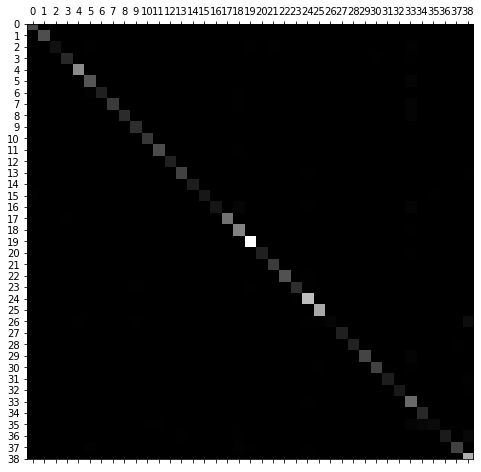

In [96]:
conf_mx = confusion_matrix(y_train,y_pred=preds)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.matshow(conf_mx, cmap=plt.cm.gray)
ax.set_xticks(range(len(target_cats)))
ax.set_yticks(range(len(target_cats)))
plt.show()

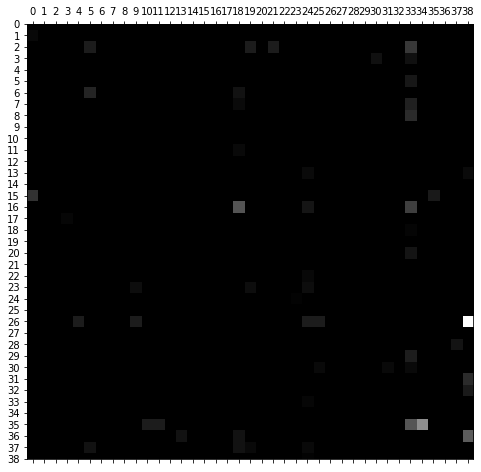

[(0, 'اتو و حالت دهنده ی مو', 49),
 (1, 'اصلاح موی صورت', 55),
 (2, 'باتری استاندارد', 17),
 (3, 'برنج', 30),
 (4, 'تبلت', 96),
 (5, 'تجهیزات جانبی ایروبیک و تناسب اندام', 62),
 (6, 'توپ', 26),
 (7, 'خودکار و روان نویس', 44),
 (8, 'دفتر', 33),
 (9, 'دوربین عکاسی', 32),
 (10, 'روغن', 38),
 (11, 'روغن موتور', 53),
 (12, 'ریمل', 22),
 (13, 'ساعت هوشمند', 48),
 (14, 'ست لباس راحتی پسرانه', 20),
 (15, 'شامپو کودک و نوزاد', 19),
 (16, 'شیرآلات', 23),
 (17, 'قفل', 79),
 (18, 'قمقمه و فلاسک', 91),
 (19, 'لپ تاپ و الترابوک', 176),
 (20, 'ماست', 24),
 (21, 'ماشین حساب', 41),
 (22, 'مداد', 57),
 (23, 'میکروفون حرفه\u200cای', 35),
 (24, 'هدفون، هدست و هندزفری', 131),
 (25, 'پاوربانک (شارژر همراه)', 116),
 (26, 'پایه نگهدارنده گوشی و تبلت', 17),
 (27, 'پنیر', 22),
 (28, 'پوشک کودک و نوزاد', 25),
 (29, 'چاقوی سفر و ابزار چند کاره', 50),
 (30, 'چندراهی برق و محافظ ولتاژ', 49),
 (31, 'کابل و مبدل', 22),
 (32, 'کارت حافظه', 18),
 (33, 'کتاب چاپی', 74),
 (34, 'کرم ضد آفتاب', 28),
 (35, 'کرم، بالم و لوسی

In [97]:
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx,0)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.matshow(norm_conf_mx, cmap=plt.cm.gray)
ax.set_xticks(range(len(target_cats)))
ax.set_yticks(range(len(target_cats)))
plt.show()
item_instances = [x[1] for x in sorted(Counter(y_train).items())]
list(zip(range(len(target_cats)),le.classes_,item_instances))

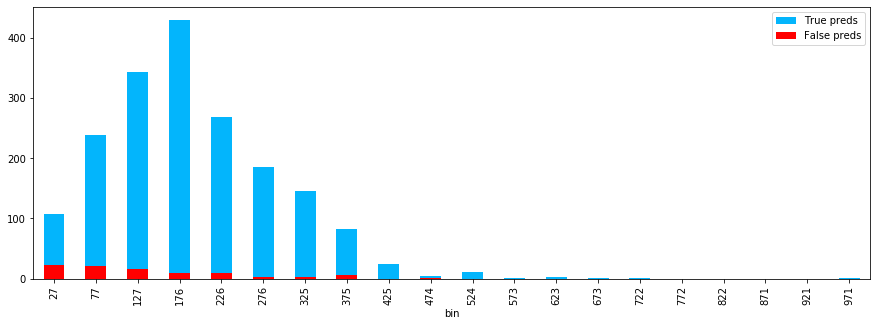

In [98]:
t = pd.DataFrame({"summary":X_train.values, "summary_len":X_train.apply(lambda s:len(s.split())).values},index=X_train.index)
num_bins = 20

bin_intervals = np.linspace(t["summary_len"].min(),t["summary_len"].max(),num=num_bins+1)
bin_labels = [int((bin_intervals[i] + bin_intervals[i+1]) / 2) for i in range(len(bin_intervals) - 1)]

t["bin"] = pd.cut(t["summary_len"],bins=num_bins,labels=bin_labels)
t.reset_index(inplace=True)

t_gb_bin = t.groupby("bin").apply(lambda x: x.index)

match = preds == y_train
match_per_length = t_gb_bin.apply(lambda indices: (match[indices].sum(), len(indices) - match[indices].sum()))
match_per_length = pd.DataFrame({"T":match_per_length.apply(lambda x: x[0]),"F":match_per_length.apply(lambda x: x[1])})

fig = plt.figure(figsize=(15,5))
(match_per_length["T"]).plot.bar(label="True preds",color="#03b5fc")
(match_per_length["F"]).plot.bar(label="False preds",color="r")
plt.legend()
plt.show()

In [99]:
start = time.time()
model = final_model
model.fit(X_train_dim_reduced[:,:ndims], y_train)
joblib.dump(model,f"saved_models/{model.__class__.__name__}.pkl")
print(f"File size: {os.path.getsize(f'saved_models/{model.__class__.__name__}.pkl')*1e-6:.2f}MB")
print(f"Fit time: {time.time() - start:.2f}s")

File size: 0.19MB
Fit time: 0.36s


In [100]:
def recommend(text,model,pca=None,ndims=None):
    x = tfidf.transform([text]).toarray()
    if pca:
        x = pca.transform(x)[:,:ndims]
#     pred = model.predict(x)
    scores = model.predict_proba(x)[0]   
#     print(sorted(scores,reverse=True))
    cats = np.nonzero(np.isclose(scores,scores.max(),atol=0,rtol=.5))
    return le.inverse_transform(cats[-1])

In [101]:
s="""
تبلتی مناسب است برای همه قشر هازیرا هم برای بازی خوب هستهم وزن سبک مناسبی داردولی از نظر بنده دو بدی داردیکی نداشتن قلم همراهیکی هم فقط بلندگو داردیعنی اگر میخواهید باهاش صحبت کنید در یک جمع عمومی باید حتما هندزفری داشته باشیدبه نظرم مناسب بود شرکت سامسونگ یک هندزفری level همراهش میذاشت
"""
recommend(s,model,pca,ndims=ndims)


array(['هدفون، هدست و هندزفری'], dtype=object)

We can use probability values and a threshold to recommend multiple categories instead of recommending just the category with highest probability.

In [102]:
%%timeit
s = "از ایام قدیم تا قرن ۱۸ میلادی، قدیمی‌ترین شکل قفل، قفلی است که در ویرانه‌های خرساباد نزدیکی نینوا، پیدا شده‌است و حدود ۴ هزار سال قدمت دارد. این قفل چوبی است و چند میله چوبی قابل حرکت دارد که در سوراخ‌هایی مناسب روی کلون می‌افتند و کلون را در وضعیت بسته نگه می‌دارند. کلید آن هم چوبی است و میله‌هایی دارد و می‌توان آن را در شیاری در کلون داخل کرد."
recommend(s,model,pca,ndims)


234 ms ± 34.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Validation on Testset

In [103]:
test_preds = final_model.predict(X_test_dim_reduced[:,:ndims])
(accuracy, f1_micro, f1_weighted ,precision_micro,precision_weighted, recall_micro,recall_weighted) = clf_metrics_values(test_preds,y_test)
print(f"accuracy:{accuracy}\nf1_micro:{f1_micro}\nf1_weighted:{f1_weighted}\nprecision_micro:{precision_micro}\nprecision_weighted:{precision_weighted}\nrecall_micro:{recall_micro},\nrecall_weighted:{recall_weighted}")


accuracy:0.9628865979381444
f1_micro:0.9628865979381444
f1_weighted:0.9628865979381444
precision_micro:0.9628865979381444
precision_weighted:0.9628865979381444
recall_micro:0.9628865979381444,
recall_weighted:0.9628865979381444


## Validation on Wikipedia Data

In [104]:
wiki_valid_data = {}
wikiscrapper_outdir = Path("wikiscrapper/outdir/")
for category in wikiscrapper_outdir.glob("*"):
    cat_name = category.stem
    with open(category,"r") as f:
        data = f.readlines()
    concatenated = "\n".join(data)
    wiki_valid_data[cat_name] = concatenated

In [105]:
window_size = 100
for catname,validation in wiki_valid_data.items():
    label = le.transform([catname])[0]
    words = validation.split()
    no_window = len(words) // window_size
    preds = []
    for i in range(no_window):
        window = " ".join(words[i*window_size:(i+1)*window_size])
        window_tfidf = tfidf.transform([window]).toarray()
        window_dim_reduced = pca.transform(window_tfidf)
        window_preds = model.predict(window_dim_reduced[:,:ndims])
        preds.extend(window_preds)
        
    last_window = " ".join(words[no_window*window_size:])
    last_window_tfidf = tfidf.transform([last_window]).toarray()
    last_window_dim_reduced = pca.transform(last_window_tfidf)
    last_window_preds = model.predict(last_window_dim_reduced[:,:ndims])
    preds.extend(last_window_preds)
    targets = np.repeat(label,len(preds))
    
    print(f"{catname} with {no_window+1} samples")
    (accuracy, _, _, _, _, _, _) = clf_metrics_values(preds,targets)
    print(f"accuracy:{accuracy:.2f}\n")        

پنیر with 4 samples
accuracy:0.50

دفتر with 11 samples
accuracy:0.64

برنج with 35 samples
accuracy:0.49

دوربین عکاسی with 8 samples
accuracy:0.25

ریمل with 2 samples
accuracy:0.50

مداد with 6 samples
accuracy:0.83

کارت حافظه with 1 samples
accuracy:1.00

توپ with 1 samples
accuracy:1.00

ماست with 11 samples
accuracy:0.73

قفل with 13 samples
accuracy:0.92

ساعت هوشمند with 4 samples
accuracy:0.75

روغن موتور with 4 samples
accuracy:1.00

تبلت with 8 samples
accuracy:0.88

روغن with 30 samples
accuracy:0.90

گوشی موبایل with 24 samples
accuracy:0.21

ماشین حساب with 10 samples
accuracy:0.80



## Furthur Works

HashingVectorizer
<br>
ngrams
<br>
NN
<br>
hyperparameter tuning